# The weather in Zurich

---

[Table of contents](index.ipynb)

---

There are several weather stations placed around the city of Zurich. One of them is operated by the "Wasserschutzpolizei". It has been collecting detailed weather data for several years and is placed close to Mythenquai.

We can get temperature, humidity, rain fall, solar radiation, and more for each 10minute period of the last few years. We can even get a reading of the water level of the lake!

In this notebook we will look at how the temperature and humidity vary over the year. We will also count the number of rainy days in 2016.

The year 2017 is not over yet, so we will use data from 2016 instead.

To get started we import a few libraries that we will need later:

In [1]:
%matplotlib inline

import urllib

import pandas as pd

Unfortunately the data is not stored in a tidy CSV file. Instead we have to construct a fairly complicated URL, then "open" it, download the web page, and then convert it into a `pandas` data frame. This sounds more complicated then it really is.

You can visit the webpage yourself: https://www.tecson-data.ch/zurich/mythenquai/. You will have to select what data (temperature, humidity, etc) you would like to see and for which days.

If you dig into what your webbrowser does when you click all the buttons you will find that it constructs a URL very similar to the one shown below. Don't worry if it doesn't all make sense.

For each of the measurements we want to download we list it (in German) as an additional `felder[]=` part in the URL. The last bit saves everything into a local file. This way we do not have to download it again and again.

In [2]:
data = ('messw_beg=01.01.2016&messw_end=31.12.2016&'
        'felder[]=Temp2m&felder[]=TempWasser&felder[]=Windchill&'
        'felder[]=LuftdruckQFE&felder[]=Regen&felder[]=Taupunkt&'
        'felder[]=Strahlung&felder[]=Feuchte&felder[]=Pegel&'
        'auswahl=2&combilog=mythenquai&suchen=Werte anzeigen')
data = data.encode('ascii')

req = urllib.request.Request(
    'https://www.tecson-data.ch/zurich/mythenquai/uebersicht/messwerte.php',
    method='POST',
    data=data,
    headers={"Content-Type": "application/x-www-form-urlencoded",
             'User-Agent': 'http://github.com/wildtreetech/explore-open-data'
            },
    )

with urllib.request.urlopen(req) as web:
    with open('weather-2016.html', 'w') as local:
        local.write(web.read().decode('iso-8859-1'))

You can look at the contents of the [`weather-2016.html` file](weather-2016.html), it contains all sorts of instructions specifying the look of the webpage, and all of our data. At first sight extracting our data looks like a big task. Luckily this is such a common task that the `pandas` library has some handy functions that do most of the work for us:

In [3]:
df = pd.read_html('weather-2016.html',
                  # a little hint to find the data in the file
                  attrs={'border': '1'},
                  # skip the first row of the data, it is junk
                  skiprows=1,
                  # convert all dates we find into datetime objects
                  parse_dates=True,
                  # and use the first column as the index, this corresponds to the date
                  index_col=0)
df = df[0]

Now that we have loaded the data, let's take a look at it:

In [4]:
df.head()

,1,2,3,4,5,6,7,8,9
0,,,,,,,,,
2016-01-01 00:00:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:10:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:20:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:30:00,6.4,7.2,6.4,977.1,0.0,6.1,0,98,405.78
2016-01-01 00:40:00,6.4,7.2,6.4,977.1,0.0,6.2,0,98,405.79


You can see lots of values from January, 1st 2016 ... but without names for the columns we can only guess what they really mean. Let's fix that by setting the column names explicitly. How do we know this is the correct way to label them? I compared the HTML we downloaded with the values in our table above and wrote out the names by hand.

In [5]:
df.columns = ['Temp', 'WaterTemp', 'Windchill', 'Pressure', 'Rain',
              'Dewpoint', 'Radiation', 'Humidity', 'Waterlevel']
df.head()

,Temp,WaterTemp,Windchill,Pressure,Rain,Dewpoint,Radiation,Humidity,Waterlevel
0,,,,,,,,,
2016-01-01 00:00:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:10:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:20:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:30:00,6.4,7.2,6.4,977.1,0.0,6.1,0,98,405.78
2016-01-01 00:40:00,6.4,7.2,6.4,977.1,0.0,6.2,0,98,405.79


This looks much better. About 6degree Celcius in the middle of the night in January makes sense, as does the fact that the solar radiation is zero. It is dark after all.

Let's get started with plotting the average temperature of each week:

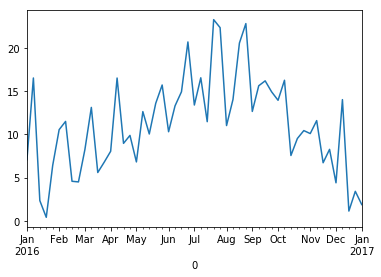

In [6]:
temperature = df['Temp']
temperature.resample('W').mean().plot();

This looks weird. An average temperature of 15C in January is unlikely, let's zoom in on the first few days of the year. Maybe we can see what is going on.

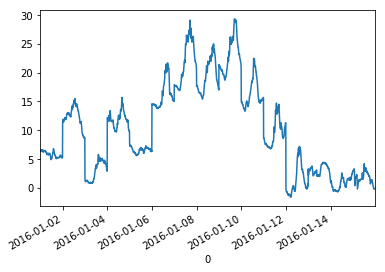

In [7]:
temperature[:"20160115"].plot();

Something is not right ... the temperature changes abruptly from around 5C to over 10C. It turns out that the way the dates are formatted in our data means pandas has to guess whether the date is in European (day first) or American (month first) formatting.

In [8]:
pd.to_datetime('01.08.2016')

Timestamp('2016-01-08 00:00:00')

In [9]:
pd.to_datetime('01.08.2016', dayfirst=True)

Timestamp('2016-08-01 00:00:00')

So, instead of letting pandas guess the format we need to specify it explicitly.

## Attempt two

next we load the data without trying to parse the dates automatically. Instead we specify explicitly the format (day first) when we convert the first column to a datetime. The first bit of code is as above, but we remove our request to parse the dates:

In [10]:
df = pd.read_html('weather-2016.html',
                  attrs={'border': '1'},
                  skiprows=1)
df = df[0]

Next we explicitly convert the first column of our dataset into a date, specifying that the day comes first:

In [11]:
df[0] = pd.to_datetime(df[0], dayfirst=True)

And as before we set the names of the columns and then specify that we want to use the date column as the index.

In [12]:
df.columns = ['Date', 'Temp', 'WaterTemp', 'Windchill', 'Pressure', 'Rain',
              'Dewpoint', 'Radiation', 'Humidity', 'Waterlevel']
df = df.set_index('Date')

In [13]:
df.head(5)

,Temp,WaterTemp,Windchill,Pressure,Rain,Dewpoint,Radiation,Humidity,Waterlevel
Date,,,,,,,,,
2016-01-01 00:00:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:10:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:20:00,6.3,7.2,6.3,977.0,0.0,6.0,0,98,405.79
2016-01-01 00:30:00,6.4,7.2,6.4,977.1,0.0,6.1,0,98,405.78
2016-01-01 00:40:00,6.4,7.2,6.4,977.1,0.0,6.2,0,98,405.79


This looks good, how about the temperature plot of the first two weeks?

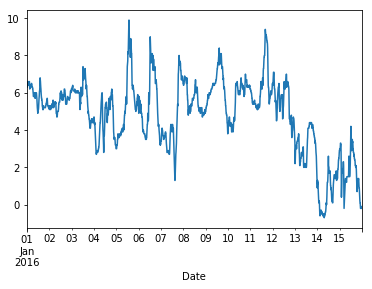

In [14]:
temperature = df['Temp']
temperature[:"20160115"].plot()

Looks much more reasonable. To check you can compare it to the values in the HTML table by hand. Now back to showing the average temperature of each week:

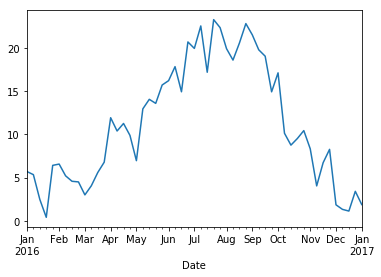

In [15]:
temperature.resample('W').mean().plot();

This looks much more like what we would expect. Cold in winter and increasingly warm towards summer. After which it cools off again.

So, after this detour to the world of dealing with loading data and parsing dates we did not yet look at the humidity and rainy days. Because there is quite a bit of code involved in fetching and loading the data there is a helper function in [`utils.py`](/edit/utils.py) called `get_weather_data()` that takes care of everything for us.

To find out about rainy days in Zurich, go to the next notebook: [Zurich weather exploration](zurich-weather-exploration.ipynb).